<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Model/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.8 MB/s eta 0:00:00


In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import shap


In [5]:
bi3 = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
bi3 = bi3.iloc[:, 1:]

In [6]:
bi3['NATNL'] = bi3['NATNL'].replace({0: 'Asian', 1: 'Asian', 3: 'Asian', 2: 'Non-Asian'})

In [7]:
bi3 = bi3.sort_values(['PatientUID', 'PatientVisitUID'])
bi3['TimeDiff'] = bi3.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
bi3['TimeDiff'] = bi3['TimeDiff'].fillna(0)

In [8]:
bi3['time_t1'] = pd.to_datetime(bi3['time_t1'])

In [9]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(bi3[column].unique())}
    bi3[column] = bi3[column].map(encoding_map)

In [10]:
def categorize_eGFR(eGFR_value):
    if eGFR_value >= 90:
        return 0
    elif eGFR_value >= 60:
        return 1
    elif eGFR_value >= 30:
        return 2
    elif eGFR_value >= 15:
        return 3
    else:
        return 4

bi3['Stage'] = bi3['eGFR_t1'].apply(categorize_eGFR)

# GridSearch

In [11]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/xgb_group_binary3.json'
with open(json_file_path, 'r') as f:
    xgb_group_binary3 = json.load(f)

print(xgb_group_binary3)

[{'fold': 1, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6493326424126196}, {'fold': 2, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6464102364749543}, {'fold': 3, 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}, 'best_score': 0.6502726006734658}, {'fold': 4, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6489193831299095}, {'fold': 5, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6492882747934101}]


In [12]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_group_binary3.json'
with open(json_file_path, 'r') as f:
    rf_group_binary3 = json.load(f)

print(rf_group_binary3)

[{'fold': 1, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6359939377634444}, {'fold': 2, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6363789957902357}, {'fold': 3, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6361862231773203}, {'fold': 4, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6346183397692711}, {'fold': 5, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6374801150718877}]


# Split

In [13]:
bi3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                    'LabCwhen', 'LabLocation', 'Fold','Slopes'], axis=1)
bi3_y = bi3['Group']

In [14]:

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = bi3.drop(['PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                'LabCwhen', 'LabLocation', 'Fold', 'Slopes','Group'], axis=1)
y = bi3['Group']
all_folds = bi3['Fold'].unique()
X_train_scaled_list_bi3 = []
y_train_list_bi3 = []
X_test_scaled_list_bi3 = []
y_test_list_bi3 = []
for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == val_fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_train_scaled_list_bi3.append(X_train_scaled)
    y_train_list_bi3.append(y_train)
    X_test_scaled_list_bi3.append(X_test_scaled)
    y_test_list_bi3.append(y_test)
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices
    print(f"Training set size: {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")


Training set size: (42184, 121)
Test set size: (10436, 121)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---

Training set size: (42017, 121)
Test set size: (10603, 121)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Training set size: (41978, 121)
Test set size: (10642, 121)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---

Training set size: (42027, 121)
Test set size: (10593, 121)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---

Training set size: (42274, 121)
Test set size: (10346, 121)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---



# XGB

In [15]:
from xgboost import XGBClassifier

In [16]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes'], axis=1)
binary3_y = bi3['Group']

In [17]:
binary3_label_encoder = LabelEncoder()
bi3['Group'] = binary3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
binary3_all_folds = bi3['Fold'].unique()

xgb_metrics_list = []
binary3_accuracy_per_fold = []
binary3_conf_mat_list = []
binary3_precision_per_fold = []
binary3_recall_per_fold = []
binary3_f1_per_fold = []
binary3_loss_per_fold = []
shap_values_list = []

In [18]:
for fold, (train_folds, test_fold) in enumerate(kf.split(binary3_all_folds)):
    train_folds = binary3_all_folds[train_folds]
    test_fold = binary3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    binary3_X_train, binary3_X_test = binary3_X[train_indices], binary3_X[test_indices]
    binary3_y_train, binary3_y_test = binary3_y[train_indices], binary3_y[test_indices]

    # Scale
    binary3_scaler = StandardScaler()
    binary3_X_train_scaled = binary3_scaler.fit_transform(binary3_X_train)
    binary3_X_test_scaled = binary3_scaler.transform(binary3_X_test)

    # Create and train XGBoost model using best parameters
    best_params = xgb_group_binary3[fold]['best_params']
    model_x2 = XGBClassifier(**best_params, objective='multi:softmax', random_state=42)
    model_x2.fit(binary3_X_train_scaled, binary3_y_train)

    # Make predictions on the test set
    binary3_y_pred = model_x2.predict(binary3_X_test_scaled)

    # Evaluate performance
    binary3_conf_mat = confusion_matrix(binary3_y_test, binary3_y_pred)
    binary3_conf_mat_list.append(binary3_conf_mat)

    binary3_accuracy = accuracy_score(binary3_y_test, binary3_y_pred)
    binary3_precision = precision_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_recall = recall_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_f1 = f1_score(binary3_y_test, binary3_y_pred, average='weighted')

    binary3_accuracy_per_fold.append(binary3_accuracy)
    binary3_precision_per_fold.append(binary3_precision)
    binary3_recall_per_fold.append(binary3_recall)
    binary3_f1_per_fold.append(binary3_f1)

    explainer = shap.TreeExplainer(model_x2)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_list.append(shap_values)

    xgb_metrics_list.append({
        'Fold': fold + 1,
        'Accuracy': binary3_accuracy_per_fold,
        'Precision': binary3_precision_per_fold,
        'Recall': binary3_recall_per_fold,
        'F1 Score': binary3_f1_per_fold,
    })

In [19]:
import pandas as pd

# Create a DataFrame for performance metrics of each fold
fold_data = {
    "Fold": [f"Fold {fold+1}" for fold in range(len(binary3_accuracy_per_fold))],
    "Accuracy (%)": [accuracy * 100 for accuracy in binary3_accuracy_per_fold],
    "Precision": binary3_precision_per_fold,
    "Recall": binary3_recall_per_fold,
    "F1-Score": binary3_f1_per_fold
}

# Create DataFrame for fold performance
fold_performance_df = pd.DataFrame(fold_data).set_index("Fold")


# Calculate overall performance metrics
overall_metrics = {
    "Accuracy (%)": sum(binary3_accuracy_per_fold) / len(binary3_accuracy_per_fold) * 100,
    "Precision": sum(binary3_precision_per_fold) / len(binary3_precision_per_fold),
    "Recall": sum(binary3_recall_per_fold) / len(binary3_recall_per_fold),
    "F1-Score": sum(binary3_f1_per_fold) / len(binary3_f1_per_fold)
}

# Create DataFrame for overall performance
overall_performance_df = pd.DataFrame(overall_metrics, index=["Overall"])

# Concatenate fold performance DataFrame with overall performance DataFrame
result_xgb = pd.concat([fold_performance_df, overall_performance_df])

# Print the concatenated DataFrame
print("\nXGBoost Performances:")
result_xgb



XGBoost Performances:


,Accuracy (%),Precision,Recall,F1-Score
Fold 1,65.184612,0.631408,0.651846,0.628303
Fold 2,64.618144,0.627277,0.646181,0.618014
Fold 3,65.842887,0.641193,0.658429,0.630805
Fold 4,65.160804,0.630735,0.651608,0.625590
Fold 5,64.977003,0.630368,0.649770,0.623623
Overall,65.156690,0.632196,0.651567,0.625267


## shap

In [20]:
shap_values.shape

(10346, 121, 3)

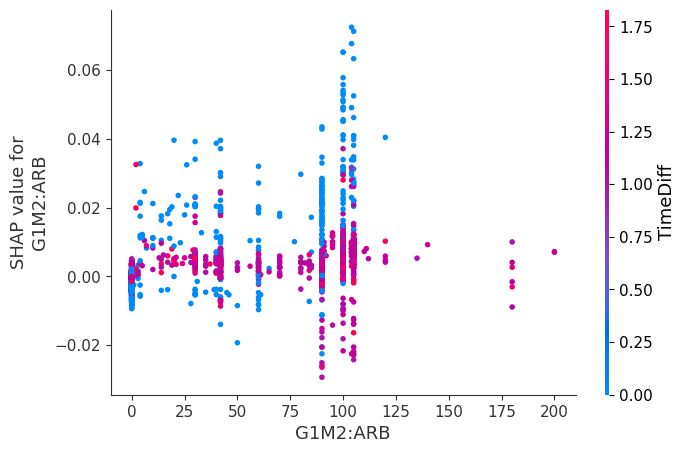

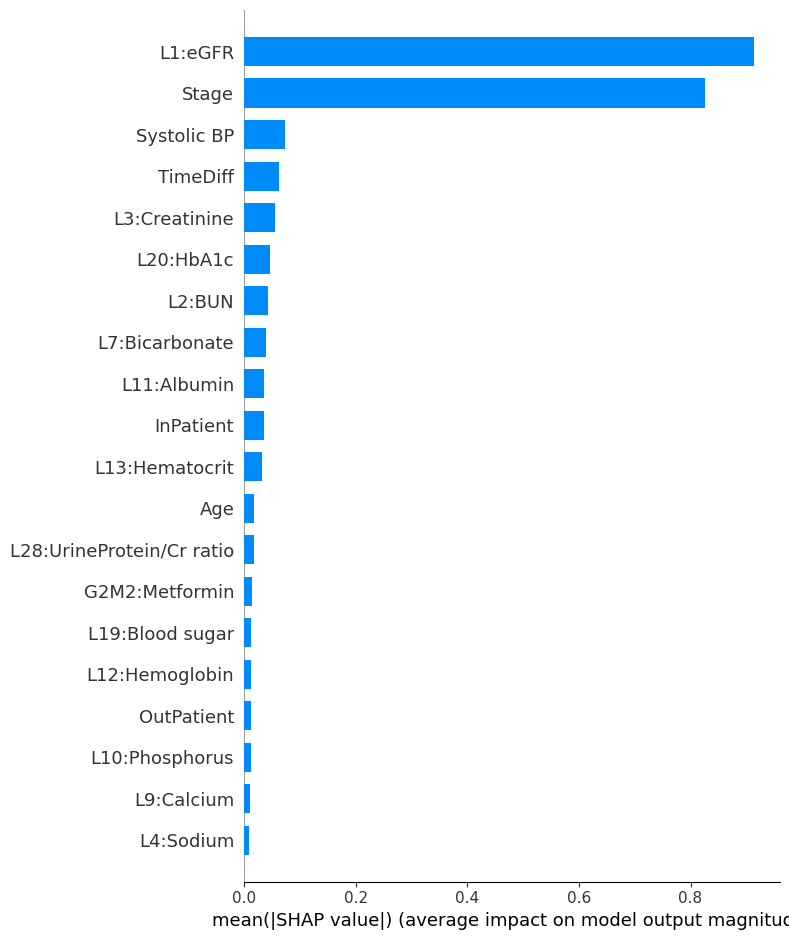

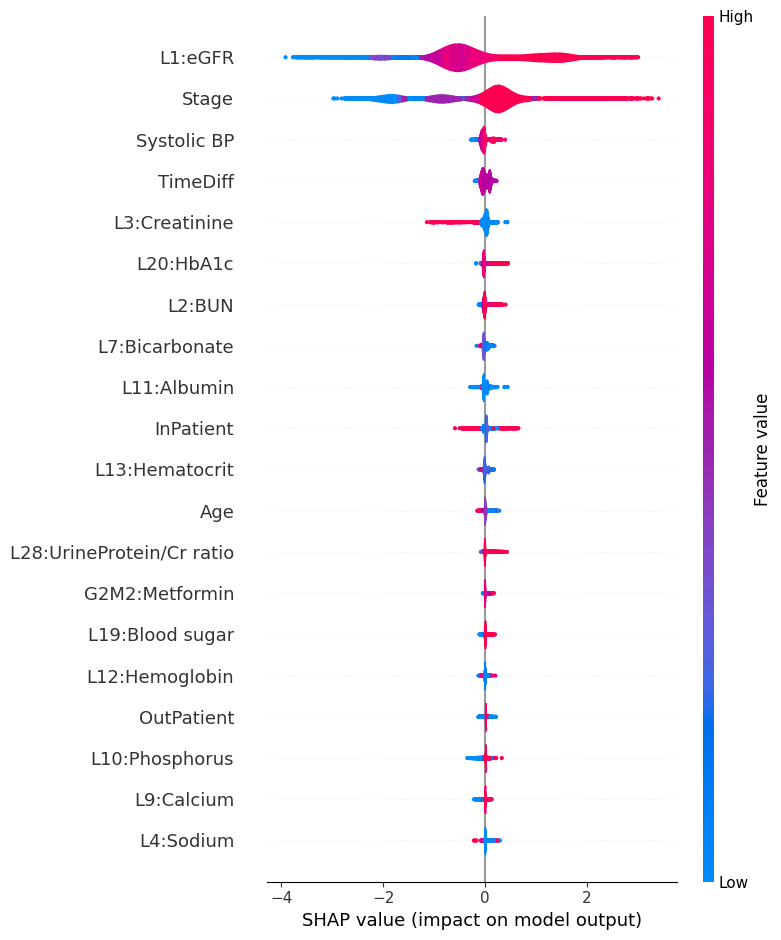

In [21]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values contains the SHAP values for each fold
fold_to_visualize = 0

# Extract SHAP values for the specified fold and class
shap_values = shap_values_list[fold_to_visualize][:X_test.shape[0], :, 0]  # Assuming you want to visualize the first class

# Dependency Plot (for a single feature, e.g., feature at index 0)
shap.dependence_plot(0, shap_values, X_test, feature_names=X.columns)

# Summary Plot (Bar Plot)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

# Summary Plot (Violin Plot)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="violin")

# Force Plot (for a single prediction, e.g., the first sample)
shap.force_plot(explainer.expected_value[0], shap_values[0, :], X_test.iloc[0, :], feature_names=X.columns)

plt.show()


# RF

In [22]:
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed

> `I've run this cell on server`



```
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = binary3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                'LabCwhen', 'LabLocation', 'Fold','Slopes'], axis=1)
y = binary3['Group']
all_folds = binary3['Fold'].unique()
grid_search_results = []

def train_and_evaluate(fold, train_indices, test_indices, X_train_scaled, X_test_scaled, y_train, y_test):
    rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(rf_model, param_grid, scoring='accuracy', cv=num_folds, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    model_rf = RandomForestClassifier(**best_params, random_state=42)
    model_rf.fit(X_train_scaled, y_train)
    y_pred = model_rf.predict(X_test_scaled)
    conf_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    #explainer = shap.TreeExplainer(model_rf)
    #shap_values = explainer.shap_values(X_test_scaled)
    return {
        'Fold': fold + 1,
        'Best Params': best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_mat,
    }```





```
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(
        fold,
        train_indices=binary3['Fold'].isin(train_folds),
        test_indices=(binary3['Fold'] == val_fold),
        X_train_scaled=scaler.fit_transform(X[train_indices]),
        X_test_scaled=scaler.transform(X[test_indices]),
        y_train=y[train_indices],
        y_test=y[test_indices]
    ) for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds))
)
rf_metrics_list = [result for result in results]```



In [23]:
import pickle

# Define the file path
file_path = "/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_metrics_list.pkl"

# Load rf_metrics_list from the saved file
with open(file_path, 'rb') as f:
    rf_metrics_list = pickle.load(f)

In [109]:
import pandas as pd

df = pd.DataFrame(rf_metrics_list)

# Compute overall metrics
overall_metrics = df.drop(columns='Fold').mean()
overall_metrics['Fold'] = 'Overall'
df = df.append(overall_metrics, ignore_index=True)
print("\nRandom Forest Performances:")
result_rf = df.set_index('Fold')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
result_rf


Random Forest Performances:


<ipython-input-109-50922f8a3efe>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  overall_metrics = df.drop(columns='Fold').mean()
<ipython-input-109-50922f8a3efe>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(overall_metrics, ignore_index=True)


,Accuracy,Precision,Recall,F1 Score
Fold,,,,
1,0.649913,0.624411,0.649913,0.614860
2,0.649913,0.624411,0.649913,0.614860
3,0.647690,0.620372,0.647690,0.613530
4,0.649913,0.624411,0.649913,0.614860
5,0.641214,0.615814,0.641214,0.599878
Overall,0.647729,0.621884,0.647729,0.611598


IndexError: index 5 is out of bounds for axis 0 with size 5

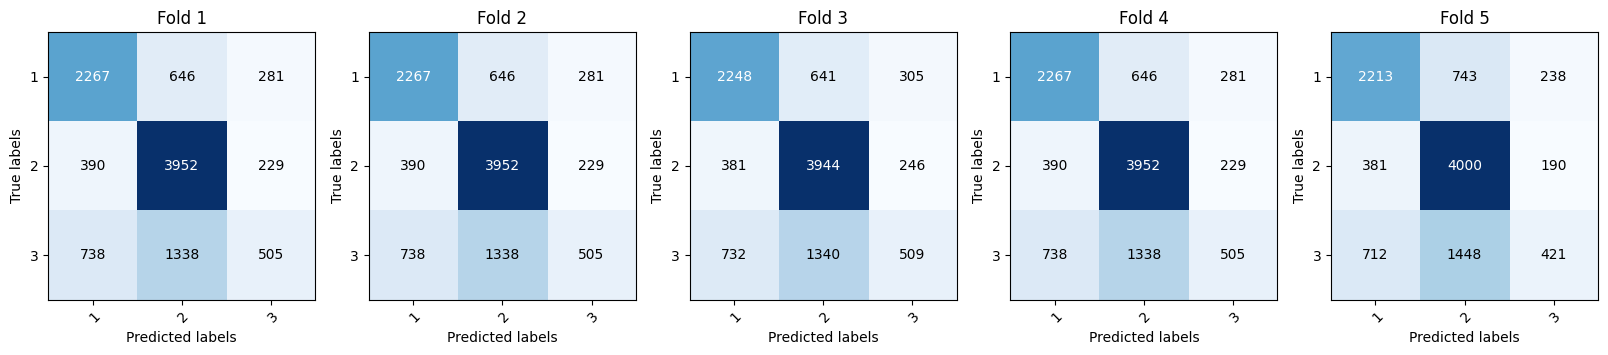

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (fold, data) in enumerate(df.iterrows()):
    ax = axes[i]
    cm = data['Confusion Matrix']
    ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_title(f'Fold {int(data["Fold"])}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(np.arange(len(cm)))
    ax.set_yticks(np.arange(len(cm)))
    ax.set_xticklabels(np.arange(1, len(cm) + 1))
    ax.set_yticklabels(np.arange(1, len(cm) + 1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(cm)):
        for j in range(len(cm)):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

## didnt use shap: run on server

# FNN

In [27]:
bi3_label_encoder = LabelEncoder()
bi3['Group'] = bi3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
bi3_all_folds = bi3['Fold'].unique()

bi3_accuracy_per_fold = []
bi3_conf_mat_list = []

bi3_precision_per_fold = []
bi3_recall_per_fold = []
bi3_f1_per_fold = []

bi3_loss_per_fold = []
bi3_all_train_loss = []
bi3_all_val_loss = []


In [28]:
for fold, (train_folds, test_fold) in enumerate(kf.split(bi3_all_folds)):
    train_folds = bi3_all_folds[train_folds]
    test_fold = bi3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    bi3_X_train, bi3_X_test = bi3_X[train_indices], bi3_X[test_indices]
    bi3_y_train, bi3_y_test = bi3_y[train_indices], bi3_y[test_indices]

    # Scale
    bi3_scaler = StandardScaler()
    bi3_X_train_scaled = bi3_scaler.fit_transform(bi3_X_train)
    bi3_X_test_scaled = bi3_scaler.transform(bi3_X_test)

    # Encode y_train and y_test

    bi3_y_train_one_hot = tf.keras.utils.to_categorical(bi3_y_train, num_classes=3)
    bi3_y_test_one_hot = tf.keras.utils.to_categorical(bi3_y_test, num_classes=len(bi3_label_encoder.classes_))

    # Build and compile the model
    bi3_model = Sequential([
        Dense(256, input_dim=bi3_X_train_scaled.shape[1], activation='relu'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
    ])

    bi3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    bi3_model.compile(optimizer=bi3_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    bi3_history = bi3_model.fit(bi3_X_train_scaled, bi3_y_train_one_hot,
                                batch_size=32,
                                epochs=80,
                                verbose=0,
                                validation_data=(bi3_X_test_scaled, bi3_y_test_one_hot))

    # Evaluate on the test set
    bi3_scores = bi3_model.evaluate(bi3_X_test_scaled, bi3_y_test_one_hot, verbose=0)
    bi3_loss_per_fold.append(bi3_scores[0])

    # Store metrics for analysis
    bi3_all_train_loss.append(bi3_history.history['loss'])
    bi3_all_val_loss.append(bi3_history.history['val_loss'])

    bi3_y_pred = bi3_model.predict(bi3_X_test_scaled)
    bi3_y_pred_classes = np.argmax(bi3_y_pred, axis=1)
    bi3_conf_mat = confusion_matrix(bi3_y_test, bi3_y_pred_classes)
    bi3_conf_mat_list.append(bi3_conf_mat)

    bi3_accuracy = accuracy_score(bi3_y_test, bi3_y_pred_classes)
    bi3_precision = precision_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_recall = recall_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_f1 = f1_score(bi3_y_test, bi3_y_pred_classes, average='weighted')

    bi3_accuracy_per_fold.append(bi3_accuracy)
    bi3_precision_per_fold.append(bi3_precision)
    bi3_recall_per_fold.append(bi3_recall)
    bi3_f1_per_fold.append(bi3_f1)

324/324 [==============================] - 1s 2ms/step


In [30]:
import pandas as pd

# Create a DataFrame for performance metrics of each fold
fold_data = {
    "Fold": [f"Fold {fold+1}" for fold in range(len(bi3_accuracy_per_fold))],
    "Accuracy (%)": [accuracy * 100 for accuracy in bi3_accuracy_per_fold],
    "Precision": bi3_precision_per_fold,
    "Recall": bi3_recall_per_fold,
    "F1-Score": bi3_f1_per_fold
}

# Create DataFrame for fold performance
fold_performance_df = pd.DataFrame(fold_data).set_index("Fold")


# Calculate overall performance metrics
overall_metrics = {
    "Accuracy (%)": sum(bi3_accuracy_per_fold) / len(bi3_accuracy_per_fold) * 100,
    "Precision": sum(bi3_precision_per_fold) / len(bi3_precision_per_fold),
    "Recall": sum(bi3_recall_per_fold) / len(bi3_recall_per_fold),
    "F1-Score": sum(bi3_f1_per_fold) / len(bi3_f1_per_fold)
}

# Create DataFrame for overall performance
overall_performance_df = pd.DataFrame(overall_metrics, index=["Overall"])

# Concatenate fold performance DataFrame with overall performance DataFrame
result_fnn = pd.concat([fold_performance_df, overall_performance_df])

# Print the concatenated DataFrame
print("\nFNN Performance to classify Group:")
result_fnn



FNN Performance to classify Group:


,Accuracy (%),Precision,Recall,F1-Score
Fold 1,62.711224,0.610406,0.627112,0.577506
Fold 2,62.736961,0.615562,0.627370,0.618092
Fold 3,63.888367,0.623348,0.638884,0.625270
Fold 4,62.983902,0.613335,0.629839,0.583494
Fold 5,63.483472,0.601929,0.634835,0.578352
Overall,63.160785,0.612916,0.631608,0.596543


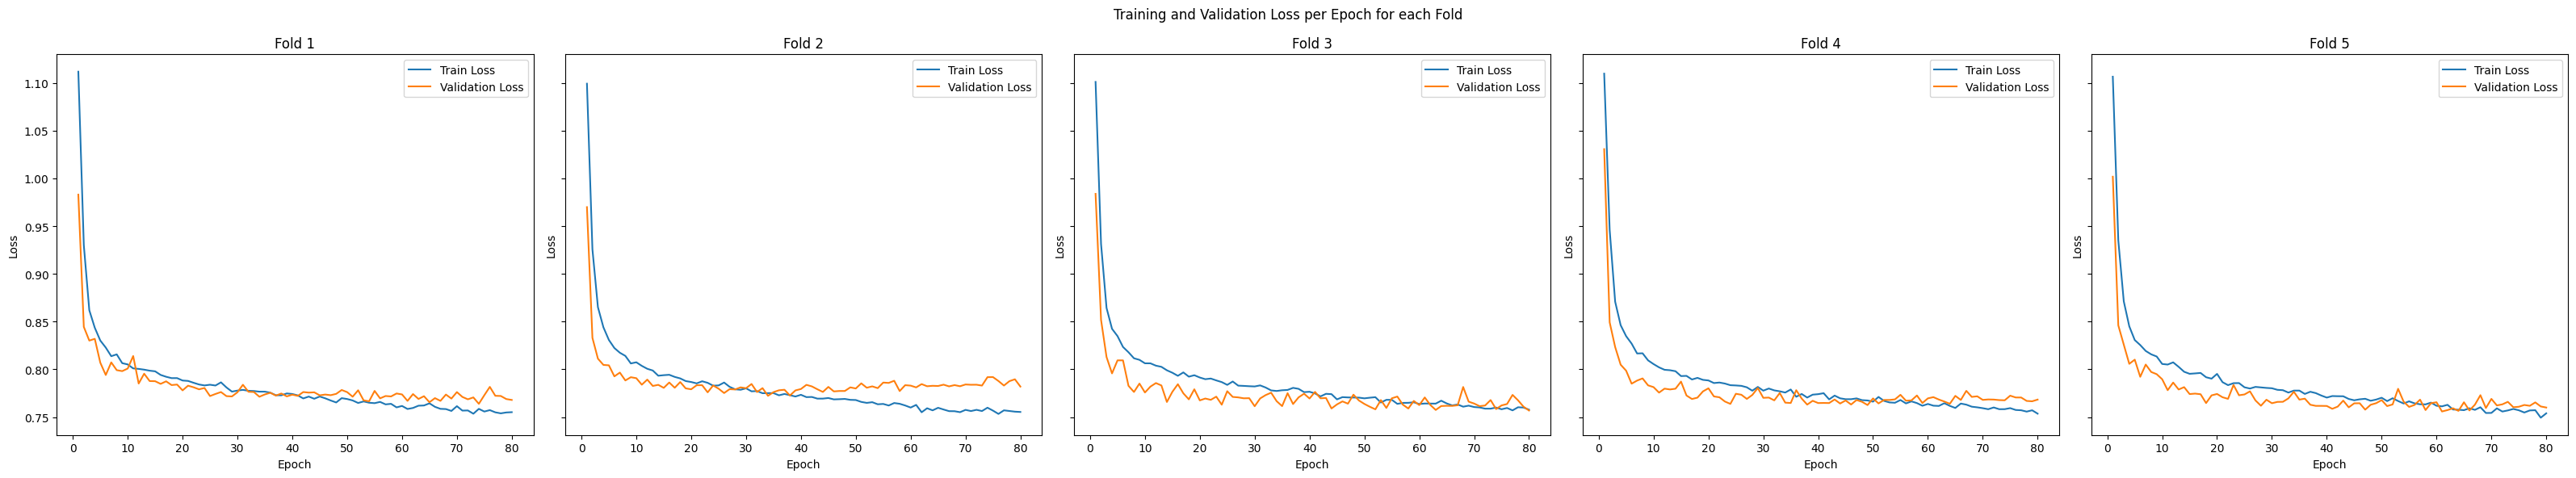

In [48]:
import matplotlib.pyplot as plt

num_epochs = len(bi3_all_train_loss[0])  # Assuming all folds have the same number of epochs

fig, axs = plt.subplots(1, num_folds, figsize=(32, 6), sharex=True, sharey=True)

for fold in range(num_folds):
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_train_loss[fold], label=f'Train Loss')
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_val_loss[fold], label=f'Validation Loss')
    axs[fold].set_title(f'Fold {fold + 1}')
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('Loss')
    axs[fold].legend()

plt.suptitle('Training and Validation Loss per Epoch for each Fold')
plt.tight_layout()
plt.show()


## shap

In [61]:
explainer = shap.Explainer(bi3_model, bi3_X_train_scaled)
shap_values = explainer.shap_values(bi3_X_train_scaled[:100])

PermutationExplainer explainer: 101it [00:38,  2.01it/s]


In [62]:
print(shap_values.shape)
print(bi3_X_train_scaled.shape)

(100, 121, 3)
(42274, 121)


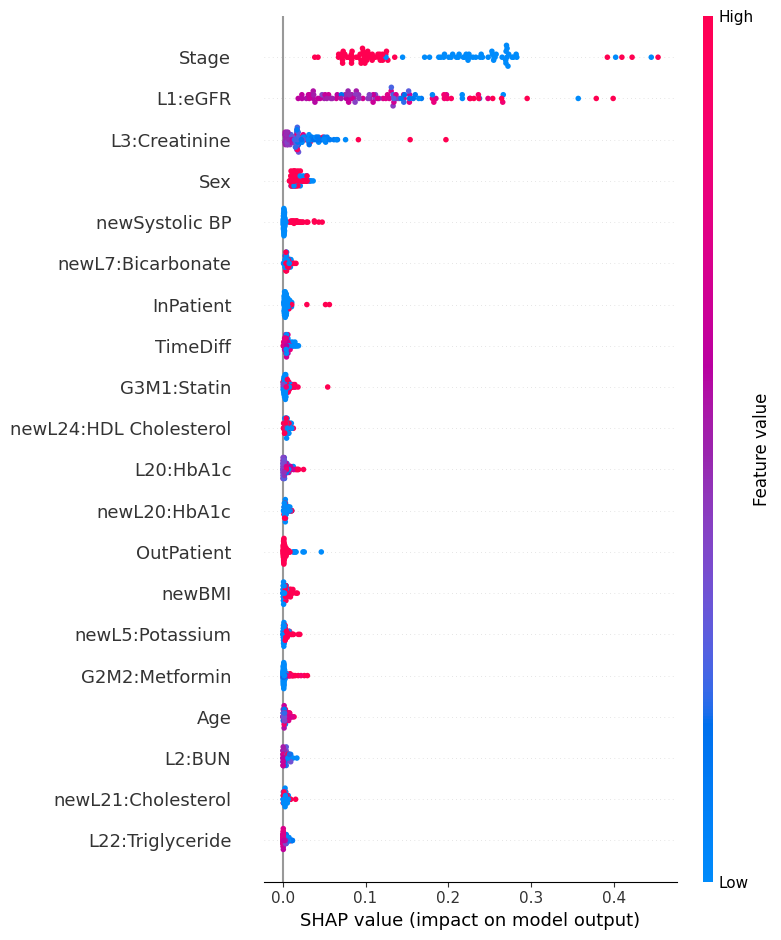

In [64]:
# Reshape shap_values array
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)

# Call summary_plot
shap.summary_plot(shap_values_reshaped, bi3_X_train_scaled[:100], feature_names=bi3_X.columns)

#Summary

In [112]:
result_rf['Accuracy'] *= 100

In [116]:
test = pd.concat([result_xgb[-1:], result_rf[-1:], result_fnn[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network'])
import pandas as pd

# Concatenating the DataFrames
test = pd.concat([result_xgb.iloc[-1:], result_rf.iloc[-1:], result_fnn.iloc[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network'])

# Remove the index named 'Overall'
test.reset_index(level=1, drop=True, inplace=True)

# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'F1-Score'] = test.loc['RandomForest', 'F1 Score']
test.drop(columns='F1 Score', inplace=True)
# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'Accuracy (%)'] = test.loc['RandomForest', 'Accuracy']
test.drop(columns='Accuracy', inplace=True)
test


,Accuracy (%),Precision,Recall,F1-Score
XGBoost,65.156690,0.632196,0.651567,0.625267
RandomForest,64.772859,0.621884,0.647729,0.611598
Feedforward Neural Network,63.160785,0.612916,0.631608,0.596543


svm ขอร้อง หละ